In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.8 MB/s eta 0:00:00


In [ ]:
# import all necessary libraries and functions

import os, math, random
import numpy as np
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet18, ResNet18_Weights

from medmnist import INFO
from medmnist.dataset import PathMNIST

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [ ]:
# configuration
class CFG:
    # path where PathMNIST data will be stored
    data_root: str = "/content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18"
    download: bool = True

    # training hyperparameters
    epochs: int = 10                # no. of training epochs
    batch_size: int = 128           # batch size
    lr: float = 3e-4                # learning rate
    weight_decay: float = 1e-4      # weight decay schedule
    warmup_epochs: int = 3          # no. of warmup epochs
    label_smoothing: float = 0.0    # label smoothing for classification loss
    amp: bool = True                # mixed precision

    # model
    use_pretrained: bool = True     # True --> ImageNet pretrained weights
    dropout: float = 0.0

    # system parameters
    workers: int = 4                # no. of dataloader workers
    seed: int = 42                  # random seed for reproducibility
    gpu: int = 0                    # GPU to use

    # path to save model checkpoints
    ckpt_path: str = "/content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18/resnet18_pathmnist_best.pth"


CFG = CFG()

# reproducibility helpers
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# apply seed
set_seed(CFG.seed)

# device setup
device = torch.device(f"cuda:{CFG.gpu}" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
# transforms
NUM_CLASSES = 9           # no. of PathMNIST tissue classes
info = INFO["pathmnist"]

# MedMNIST default normalisation values
pm_mean = (0.5, 0.5, 0.5)
pm_std = (0.5, 0.5, 0.5)

# training data transformations
train_tfms = transforms.Compose([
    # random crop + resize image to 224x224, scale crop between 80%-100% of original image
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), interpolation=InterpolationMode.BILINEAR),
    # random horizontal flip
    transforms.RandomHorizontalFlip(),
    # convert PIL image to PyTorch tensor
    transforms.ToTensor(),
    # normalise channels using MedMNIST default mean and std
    transforms.Normalize(mean=pm_mean, std=pm_std),
])
# validation/testing data transformations
eval_tfms = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    # crop central region 224x224
    transforms.CenterCrop(224),
    # convert PIL image to PyTorch tensor
    transforms.ToTensor(),
    # normalise channels using MedMNIST default mean and std
    transforms.Normalize(mean=pm_mean, std=pm_std),
])

# load PathMNIST training, validation and testing splits
train_set = PathMNIST(root=CFG.data_root, split="train", transform=train_tfms, download=CFG.download, as_rgb=True)
val_set   = PathMNIST(root=CFG.data_root, split="val",   transform=eval_tfms, download=CFG.download, as_rgb=True)
test_set  = PathMNIST(root=CFG.data_root, split="test",  transform=eval_tfms, download=CFG.download, as_rgb=True)

# create PyTorch DataLoaders
train_loader = DataLoader(train_set, batch_size=CFG.batch_size, shuffle=True,  num_workers=CFG.workers, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.workers, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.workers, pin_memory=True)

# print dataset sizes
print(f"Train/Val/Test sizes: {len(train_set)}/{len(val_set)}/{len(test_set)}")

# extract label names
label_text = list(INFO["pathmnist"]["label"].values())

Train/Val/Test sizes: 89996/10004/7180


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# model build (ResNet-18)
def build_resnet18(num_classes: int, pretrained: bool, dropout: float = 0.0):
    # select pretrained weights
    weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
    # load ResNet-18 model
    model = resnet18(weights=weights)

    # final fully-connected layer
    in_features = model.fc.in_features
    if dropout > 0:
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(in_features, num_classes)
        )
    else:
        # linear calssifier
        model.fc = nn.Linear(in_features, num_classes)
    return model

# move to GPU
model = build_resnet18(NUM_CLASSES, pretrained=CFG.use_pretrained, dropout=CFG.dropout).to(device)

# optimiser + lr scheduler
# Adam + weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
# no. of steps for warmup + cosine schedule
steps_per_epoch = math.ceil(len(train_set) / CFG.batch_size)
warmup_steps = CFG.warmup_epochs * steps_per_epoch
total_steps  = CFG.epochs * steps_per_epoch

def lr_lambda(step):
    # warmup stage
    if step < warmup_steps:
        return (step + 1) / max(1, warmup_steps)
    # cosine decay stage
    progress = (step - warmup_steps) / max(1, (total_steps - warmup_steps))
    return 0.5 * (1 + math.cos(math.pi * progress))

# lr schedule
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
scaler = torch.cuda.amp.GradScaler(enabled=CFG.amp)

# evaluation helper
def evaluate(model, loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_targets, all_preds = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.squeeze().long().to(device, non_blocking=True)

        # forward pass
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        # tracking loss + accuracy
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

        # storing predictions for later evaluation metrics
        all_targets.append(y.detach().cpu())
        all_preds.append(pred.detach().cpu())

    # compute accuracy + mean loss
    acc = correct / total
    y_true = torch.cat(all_targets).numpy()
    y_pred = torch.cat(all_preds).numpy()
    return acc, loss_sum / total, y_true, y_pred

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 82.9MB/s]
/tmp/ipython-input-2711384312.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=CFG.amp)


In [ ]:
# training loop
best_val = 0.0      # tracking best validation accuracy
best_state = None   # storing best model checkpoint

for epoch in range(CFG.epochs):
    model.train()   # setting model to training mode
    running = 0.0   # training loss

    # progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFG.epochs}")
    for x, y in pbar:
        # move to GPU
        x = x.to(device, non_blocking=True)
        y = y.squeeze().long().to(device, non_blocking=True)

        # resetting gradients
        optimizer.zero_grad(set_to_none=True)

        # forward + loss
        with torch.cuda.amp.autocast(enabled=CFG.amp):
            logits = model(x)
            loss = F.cross_entropy(logits, y, label_smoothing=CFG.label_smoothing)
        # backward + optimiser step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # lr update
        scheduler.step()
        # tracking training loss for logging
        running += loss.item() * y.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{optimizer.param_groups[0]['lr']:.2e}")

    # average training loss
    train_loss = running / len(train_set)
    # evaluate on validation set
    val_acc, val_loss, _, _ = evaluate(model, val_loader)
    print(f"Epoch {epoch+1:03d}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc*100:.2f}%")

    # save model when validation accuracy increases
    if val_acc > best_val:
        best_val = val_acc
        best_state = {
            "model": model.state_dict(),
            "val_acc": best_val,
            "epoch": epoch + 1,
            "cfg": CFG.__dict__,
        }
        torch.save(best_state, CFG.ckpt_path)
        print(f"Saved best checkpoint: {CFG.ckpt_path} (val_acc={best_val*100:.2f}%)")

Epoch 1/10:   0%|          | 0/704 [00:00<?, ?it/s]

/tmp/ipython-input-860312368.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.amp):


Epoch 001: train_loss=0.4773 | val_loss=0.2081 | val_acc=93.23%
Saved best checkpoint: /content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18/resnet18_pathmnist_best.pth (val_acc=93.23%)


Epoch 2/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 002: train_loss=0.0926 | val_loss=0.1334 | val_acc=95.99%
Saved best checkpoint: /content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18/resnet18_pathmnist_best.pth (val_acc=95.99%)


Epoch 3/10:   0%|          | 0/704 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b8235029b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b8235029b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 003: train_loss=0.0801 | val_loss=0.1663 | val_acc=94.76%


Epoch 4/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 004: train_loss=0.0585 | val_loss=0.1187 | val_acc=96.17%
Saved best checkpoint: /content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18/resnet18_pathmnist_best.pth (val_acc=96.17%)


Epoch 5/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 005: train_loss=0.0499 | val_loss=0.0491 | val_acc=98.38%
Saved best checkpoint: /content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18/resnet18_pathmnist_best.pth (val_acc=98.38%)


Epoch 6/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 006: train_loss=0.0295 | val_loss=0.0383 | val_acc=98.63%
Saved best checkpoint: /content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18/resnet18_pathmnist_best.pth (val_acc=98.63%)


Epoch 7/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 007: train_loss=0.0182 | val_loss=0.0218 | val_acc=99.36%
Saved best checkpoint: /content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18/resnet18_pathmnist_best.pth (val_acc=99.36%)


Epoch 8/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 008: train_loss=0.0101 | val_loss=0.0168 | val_acc=99.44%
Saved best checkpoint: /content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18/resnet18_pathmnist_best.pth (val_acc=99.44%)


Epoch 9/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 009: train_loss=0.0052 | val_loss=0.0136 | val_acc=99.53%
Saved best checkpoint: /content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18/resnet18_pathmnist_best.pth (val_acc=99.53%)


Epoch 10/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 010: train_loss=0.0035 | val_loss=0.0119 | val_acc=99.61%
Saved best checkpoint: /content/drive/MyDrive/Colab Notebooks/DISSERTATION/CNNs/ResNet-18/resnet18_pathmnist_best.pth (val_acc=99.61%)


In [ ]:
# final test
if os.path.isfile(CFG.ckpt_path):
    # load checkpoint
    ckpt = torch.load(CFG.ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"])  # load best model parameters
    print(f"Loaded best epoch: {ckpt.get('epoch', '?')}, best val_acc: {ckpt.get('val_acc', 0)*100:.2f}%")

# run evaluation on final test set
test_acc, test_loss, y_true, y_pred = evaluate(model, test_loader)

# print results
print(f"\nTEST: loss={test_loss:.4f} | acc={test_acc*100:.2f}%\n")

Loaded best epoch: 10, best val_acc: 99.61%

TEST: loss=0.4116 | acc=90.96%



              precision    recall  f1-score   support

           0     0.9662    0.9185    0.9418      1338
           1     0.8982    1.0000    0.9464       847
           2     0.8196    0.9381    0.8748       339
           3     0.9575    0.9953    0.9760       634
           4     0.9957    0.8879    0.9387      1035
           5     0.7053    0.8733    0.7804       592
           6     0.9211    0.9447    0.9327       741
           7     0.8768    0.4394    0.5854       421
           8     0.9179    0.9611    0.9390      1233

    accuracy                         0.9096      7180
   macro avg     0.8954    0.8843    0.8795      7180
weighted avg     0.9150    0.9096    0.9061      7180



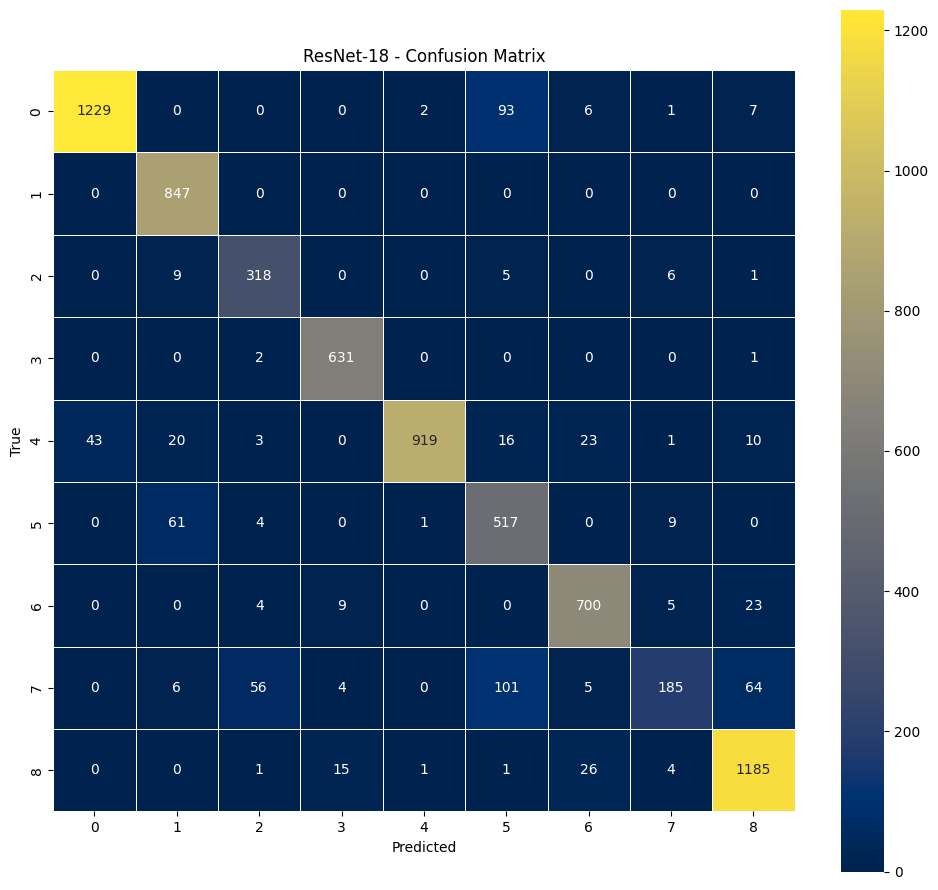

In [ ]:
# classification report
print(classification_report(y_true, y_pred, digits=4))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
NUM_CLASSES = cm.shape[0]

plt.figure(figsize=(10, 9))
ax = sns.heatmap(
    cm,
    annot=True,       # show counts
    fmt="d",          # integers
    cmap="cividis",
    cbar=True,
    square=True,
    xticklabels=np.arange(NUM_CLASSES),
    yticklabels=np.arange(NUM_CLASSES),
    linewidths=0.5,
    linecolor="white"
)
ax.set_title("ResNet-18 - Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.show()